In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


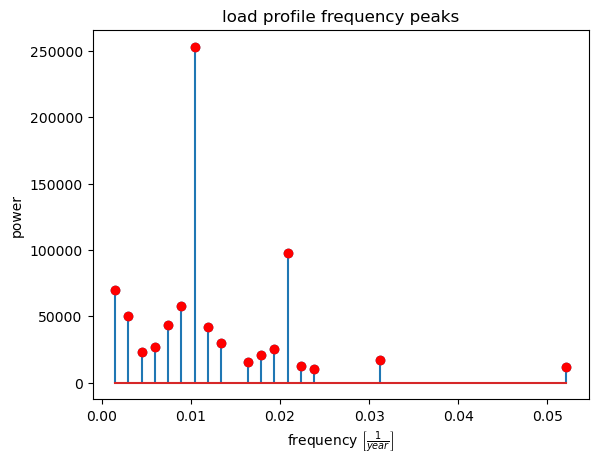

In [2]:
# load data into dataframe
from utils import get_peak_frequencies, engineer_features
bldg_221122 = pd.read_parquet("./data/221122-0.parquet").set_index('timestamp')
load_profile = pd.DataFrame(bldg_221122['out.electricity.total.energy_consumption'])
peak_freqs = get_peak_frequencies(load_profile, show_plot=True)
df = engineer_features(load_profile, peak_freqs)




In [25]:


X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)
train_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
test_dmatrix = xgb.DMatrix(data=X_test)

params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 25, 'alpha': 10}

# cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=100,
#                     num_boost_round=50,early_stopping_rounds=25,metrics="rmse", as_pandas=True, seed=123)

# cv_results
# from Vladimir@stackoverflow: https://stackoverflow.com/questions/66681443/how-can-i-get-the-trained-model-from-xgboost-cv
class SaveBestModel(xgb.callback.TrainingCallback):
    def __init__(self, cvboosters):
        self._cvboosters = cvboosters
    
    def after_training(self, model):
        self._cvboosters[:] = [cvpack.bst for cvpack in model.cvfolds]
        return model
cv_boosters = []

cv_results = xgb.cv(dtrain=train_dmatrix, params=params, nfold=50,
                    num_boost_round=50, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True, seed=0,
                    callbacks=[SaveBestModel(cv_boosters), ])

KeyboardInterrupt: 

In [23]:
cv_results.sort_values('test-rmse-std').iloc[0]
best_model = cv_boosters[cv_results.sort_values('test-rmse-std').iloc[0].name]


AttributeError: 'Booster' object has no attribute 'fit'

In [24]:
best_model.predict(X_train, y_train)

TypeError: ('Expecting data to be a DMatrix object, got: ', <class 'pandas.core.frame.DataFrame'>)

In [2]:
metadata = pd.read_parquet('metadata.parquet')
col_list = metadata.columns.tolist()


In [21]:
# find a building to use
# metadata[metadata[('in.climate_zone_ashrae_2004' == "1A") & ('in.building_type' == "Outpatient")]]
metadata[(metadata['in.climate_zone_ashrae_2004'] == "1A")]
metadata[(metadata['in.building_type'] == "Outpatient")]
inpatient_metadata = metadata[(metadata['in.climate_zone_ashrae_2004'] == "1A") & (metadata['in.building_type'] == "Outpatient")].reset_index()

inpatient_metadata[inpatient_metadata['bldg_id'] == 221122].T

,63
bldg_id,221122
applicability,True
in.upgrade_name,Baseline
in.tstat_clg_delta_f,999.0
in.tstat_clg_sp_f,999.0
in.tstat_htg_delta_f,999.0
in.tstat_htg_sp_f,999.0
in.aspect_ratio,1.0
in.building_subtype,None
in.county,G1200860


In [196]:
bldg_221122 = pd.read_parquet("./data/221122-0.parquet").set_index('timestamp')
load_profile = bldg_221122['out.electricity.total.energy_consumption']


def get_peak_frequencies(df:pd.DataFrame, show_plot=False):
    xt = df.index
    yt = df.values
    fft_output = fft(yt)
    power = np.abs(fft_output)
    freqs = fftfreq(len(fft_output))

    peaks = find_peaks(power[freqs >=0], prominence=10**4)[0] # get most prominent frequencies
    peak_freqs =  freqs[peaks]
    peak_power = power[peaks]
    if show_plot == True:
        plt.stem(peak_freqs, peak_power)
        plt.plot(peak_freqs, peak_power, 'ro')
        plt.title("load profile frequency peaks")
        plt.xlabel("frequency $\left[ \\frac{1}{year} \\right]$")
        plt.ylabel("power")
        plt.show()
    return peak_freqs

def engineer_features(df:pd.DataFrame, peak_freqs:np.array=np.array([])):
    df = df.copy()
    if type(df.index != np.datetime64):
        print("shits fucked")
        df.index = pd.to_datetime(df.index)
        print(df.index[0])
    df['day_names'] = df.index.day_name()
    df = df.join(pd.get_dummies(df.index.day_name()).set_index(df.index))

    df['day_of_week'] = df.index.day_of_week
    df['day_of_year'] = df.index.day_of_year
    df['weekend'] = df['day_names'].apply(lambda x: x in ["Saturday", "Sunday"])
    
    cal = calendar()
    sd = df.index.min().date()
    ed = df.index.max().date()
    holidays = cal.holidays(start = sd, end = ed)
    df['is_holiday'] = pd.to_datetime(load_profile.index.date).isin(holidays)

    obs_num = df.reset_index().index

    for freq in peak_freqs:
        df[f'sin_{int(freq * df.shape[0])}_py'] = np.array(np.sin( 1 / df.shape[0] * 2 * np.pi * obs_num* freq))
        df[f'cos_{int(freq * df.shape[0])}_py'] = np.array(np.cos( 1 / df.shape[0] * 2 * np.pi * obs_num * freq))

    cols = [colname for colname in df.columns.tolist() if colname != "day_names"]
    
    return df[cols[1:] + cols[:1]]
# engineer_features(pd.DataFrame(load_profile), peak_freq)



array([  52.,  104.,  156.,  209.,  261.,  313.,  365.,  417.,  469.,
        574.,  626.,  678.,  730.,  782.,  834., 1095., 1825.])

In [186]:
df = pd.DataFrame(load_profile)
if type(df.index != np.datetime64):
    print("shits fucked")
    df.index = pd.to_datetime(df.index)
    print(df.index[0])
df['day_names'] = df.index.day_name()
df
# pd.merge(pd.get_dummies(df.index.day_name()).set_index(df.index), df)
df.join(pd.get_dummies(df.index.day_name()).set_index(df.index))

shits fucked
2018-01-01 00:15:00


,out.electricity.total.energy_consumption,day_names,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
timestamp,,,,,,,,,
2018-01-01 00:15:00,8.267236,Monday,0,1,0,0,0,0,0
2018-01-01 00:30:00,8.269804,Monday,0,1,0,0,0,0,0
2018-01-01 00:45:00,8.271807,Monday,0,1,0,0,0,0,0
2018-01-01 01:00:00,8.272570,Monday,0,1,0,0,0,0,0
2018-01-01 01:15:00,8.266240,Monday,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2018-12-31 23:00:00,8.383031,Monday,0,1,0,0,0,0,0
2018-12-31 23:15:00,8.383271,Monday,0,1,0,0,0,0,0
2018-12-31 23:30:00,8.379638,Monday,0,1,0,0,0,0,0


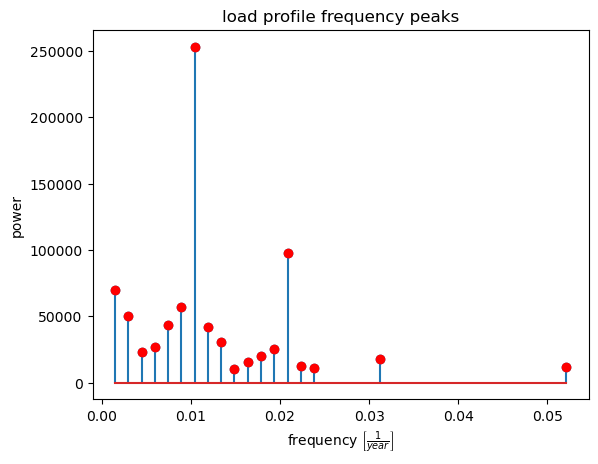

In [86]:
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks



xt = load_profile.index[:-1]
yt = load_profile.values[:-1]
fft_output = fft(yt)
power = np.abs(fft_output)
freqs = fftfreq(len(fft_output))

peaks = find_peaks(power[freqs >=0], prominence=10**4)[0] # get most prominent frequencies
peak_freq =  freqs[peaks]
peak_power = power[peaks]
plt.stem(peak_freq, peak_power)
plt.plot(peak_freq, peak_power, 'ro')
plt.title("load profile frequency peaks")
plt.xlabel("frequency $\left[ \\frac{1}{year} \\right]$")
plt.ylabel("power")
plt.show()

In [115]:
df = pd.DataFrame(load_profile)
obs_num = df.reset_index().index
np.array(np.sin( 1 / df.shape[0] * 2 * np.pi * obs_num))

array([ 0.        ,  0.00017931,  0.00035863, ..., -0.00053794,
       -0.00035863, -0.00017931])

In [179]:
pd.get_dummies(pd.DataFrame(load_profile).index.day_name()).set_index(df.index)



,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
timestamp,,,,,,,
2018-01-01 00:15:00,0,1,0,0,0,0,0
2018-01-01 00:30:00,0,1,0,0,0,0,0
2018-01-01 00:45:00,0,1,0,0,0,0,0
2018-01-01 01:00:00,0,1,0,0,0,0,0
2018-01-01 01:15:00,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
2018-12-31 23:00:00,0,1,0,0,0,0,0
2018-12-31 23:15:00,0,1,0,0,0,0,0
2018-12-31 23:30:00,0,1,0,0,0,0,0


In [60]:
pd.to_datetime(load_profile.index.date).isin(holidays)

array([ True,  True,  True, ..., False, False, False])